In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
START_YEAR = 1992
END_YEAR = 2020
HEM = 'sh'

In [ ]:
PATH_SOURCE = "/home/jbassham/jack/data/sh/inputs"

# Load stats for denormalization
fnam = f'stats_for_normalization_{HEM}_{START_YEAR}_{END_YEAR}.npz'
data = data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)

ui_m = data['ui_m'] 
vi_m = data['vi_m'] 
r_m = data['r_m'] 
ic_m = data['ic_m']

ui_std = data['ui_std'] 
vi_std = data['vi_std'] 
r_std_star = data['r_std']
ic_std = data['ic_std']

print("Stats loaded")

# Load Uncertainty
fnam = f'inputs_normalized_{HEM}_{START_YEAR}_{END_YEAR}.npz'
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
rt = data['rtn']

# Load time (dates)
fnam = f"time_today_{HEM}_{START_YEAR}_{END_YEAR}.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
time_today = data['time_today']

# Latitude Longitude Grid for plotting
fnam = f'lat_lon_{HEM}.npz'
data = np.load(os.path.join(PATH_SOURCE, fnam))
lat = data['lat']
lon = data['lon']

print("Other Variables Loaded")

Stats loaded
Other Variables Loaded


In [ ]:
PATH_SOURCE = "/home/jbassham/jack/data/sh/inputs/cnn_inputs"

# Load CNN data split indices and land mask
fnam = f'indices_land_{HEM}_{START_YEAR}_{END_YEAR}.npz'
data = np.load(os.path.join(PATH_SOURCE, fnam))
train_idx = data['train_idx']
val_idx = data['val_idx']
test_idx = data['test_idx']
land_mask = data['land_mask']

print("Indices and Land Mask Loaded")

In [ ]:
PATH_SOURCE = "/home/jbassham/jack/data/sh/outputs"

# Load CNN predictions
fnam = "CNNPreds_sh_1992_2020_weightedtorchV1.npz"
data = data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
yPredCNN = data['y_pred']
yTrueCNN = data['y_true']

uPredC = yPredCNN[:,0,:,:]
uTrueC = yTrueCNN[:,0,:,:]
vPredC = yPredCNN[:,1,:,:]
vTrueC = yTrueCNN[:,1,:,:]

# Load Weighted CNN predictions
fnam = 'CNNPreds_v1.npz'
data = data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
yPredW = data['y_pred']
yTrueW = data['y_true']

uPredW = yPredW[:,0,:,:]
uTrueW = yTrueW[:,0,:,:]
vPredW = yPredW[:,1,:,:]
vTrueW = yTrueW[:,1,:,:]

# Load LR Predictions
fnam = "LRPreds_v1.npz"
data = data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
yPredLR = data['y_pred']
yTrueLR = data['y_true']

uPredLR = np.real(yPredLR)
uTrueLR = np.real(yTrueLR)
vPredLR = np.imag(yPredLR)
vTrueLR = np.imag(yTrueLR)

# Load Baseline Predictions
fnam = 'BaselinePreds.npz'
data = data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
yPredB = data['y_pred']
yTrueB = data['y_true']

uPredB = yPredB[:,0,:,:]
uTrueB = yTrueB[:,0,:,:]
vPredB = yPredB[:,1,:,:]
vTrueB = yTrueB[:,1,:,:]

print("Predcitions Loaded")

Predcitions Loaded


In [6]:
# Un-normalize predictions

uPCun = (uPredC * ui_std) + ui_m  
uPWun = (uPredW * ui_std) + ui_m  
uPBun = (uPredB * ui_std) + ui_m  
uPLun = (uPredLR * ui_std) + ui_m


uTCun = (uTrueC * ui_std) + ui_m
uTWun = (uTrueW * ui_std) + ui_m
uTBun = (uTrueB * ui_std) + ui_m
uTLun = (uTrueLR * ui_std) + ui_m


vPCun = (vPredC * vi_std) + vi_m
vPWun = (vPredW * vi_std) + vi_m
vPBun = (vPredB * vi_std) + vi_m
vPLun = (vPredLR * vi_std) + vi_m

vTCun = (vTrueC * vi_std) + vi_m
vTWun = (vTrueW * vi_std) + vi_m
vTBun = (vTrueB * vi_std) + vi_m
vTLun = (vTrueLR * vi_std) + vi_m


rtun = (rt * r_std) + r_m

print("Predcitions Un-normalized")

Predcitions Un-normalized


In [7]:
years = time_today.astype('datetime64[Y]').astype(int) + 1970

# Define ranges
test_mask  = (years >= 2019) & (years <= 2020)

# Get indices
test_idx  = np.where(test_mask)[0]

# Crop to test indices
rtTest = rtun[test_idx,:,:]
tTest = time_today[test_idx]

print("Years Cropped")

Years Cropped


In [8]:
def weighted_skill(fit, true, r, eps = 1e-4):
    
    skill_weighted = 1 - np.nanvar((true - fit) / r, axis = 0) / (np.nanvar(true / r, axis = 0) + eps)
    
    return skill_weighted

def skill(fit, true, eps = 1e-4):
    
    skill = 1 - np.nanvar(true - fit, axis = 0) / (np.nanvar(true, axis = 0) + eps)
    # Check where true variance really small!
    
    return skill

def return_plot_skill(u_pred, u_true, v_pred, v_true, lat, lon, model):

    vmin = -1
    vmax = 1
    cmap = plt.cm.RdBu
    
    skill_u = skill(u_pred, u_true)
    skill_v = skill(v_pred, v_true)
    
    data = [skill_u, skill_v]
    nd = len(data)
    titles = ['zonal ice velocity ', 'meridional ice velocity']
    
    fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*4), constrained_layout=True)
    
    for i in range(nd):
        pcm = axs[i].pcolormesh(lon, lat, data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Skill')
        axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')
        
    fig.suptitle(f'{model} Skill', fontweight = 'bold')

    # # Save plot
    # fnam = f'{model}_skill.jpeg'
    # plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')  
    
    return skill_u, skill_v

def correlation(fit, true):
    fit_mean = np.nanmean(fit, axis = 0)
    true_mean = np.nanmean(true, axis = 0)
    
    corr1 = np.nansum((fit - fit_mean) * (true - true_mean), axis = 0)
    corr2 = np.sqrt(np.nansum((fit - fit_mean)**2, axis = 0)) * np.sqrt(np.nansum((true - true_mean)**2, axis = 0))
    
    return corr1 / (corr2)


def return_plot_correlation(u_pred, u_true, v_pred, v_true, lat, lon, model):

    vmin = -1
    vmax = 1
    cmap = plt.cm.RdBu
    
    corr_u = correlation(u_pred, u_true)
    corr_v = correlation(v_pred, v_true)
    
    data = [corr_u, corr_v]
    nd = len(data)
    titles = ['zonal ice velocity ', 'meridional ice velocity']
    
    fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*4), constrained_layout=True)
    
    for i in range(nd):
        pcm = axs[i].pcolormesh(lon, lat, data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label='Correlation')
        axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')
        
    fig.suptitle(f'{model} Correlation', fontweight = 'bold')

    # Save plot
    fnam = f'{model}_correlation.jpeg'
    plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')
    
    return corr_u, corr_v

/tmp/ipykernel_3565505/2545280244.py:9: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / (np.nanvar(true, axis = 0) + eps)
/tmp/ipykernel_3565505/2545280244.py:43: RuntimeWarning: Mean of empty slice
  fit_mean = np.nanmean(fit, axis = 0)
/tmp/ipykernel_3565505/2545280244.py:44: RuntimeWarning: Mean of empty slice
  true_mean = np.nanmean(true, axis = 0)
/tmp/ipykernel_3565505/2545280244.py:49: RuntimeWarning: invalid value encountered in divide
  return corr1 / (corr2)


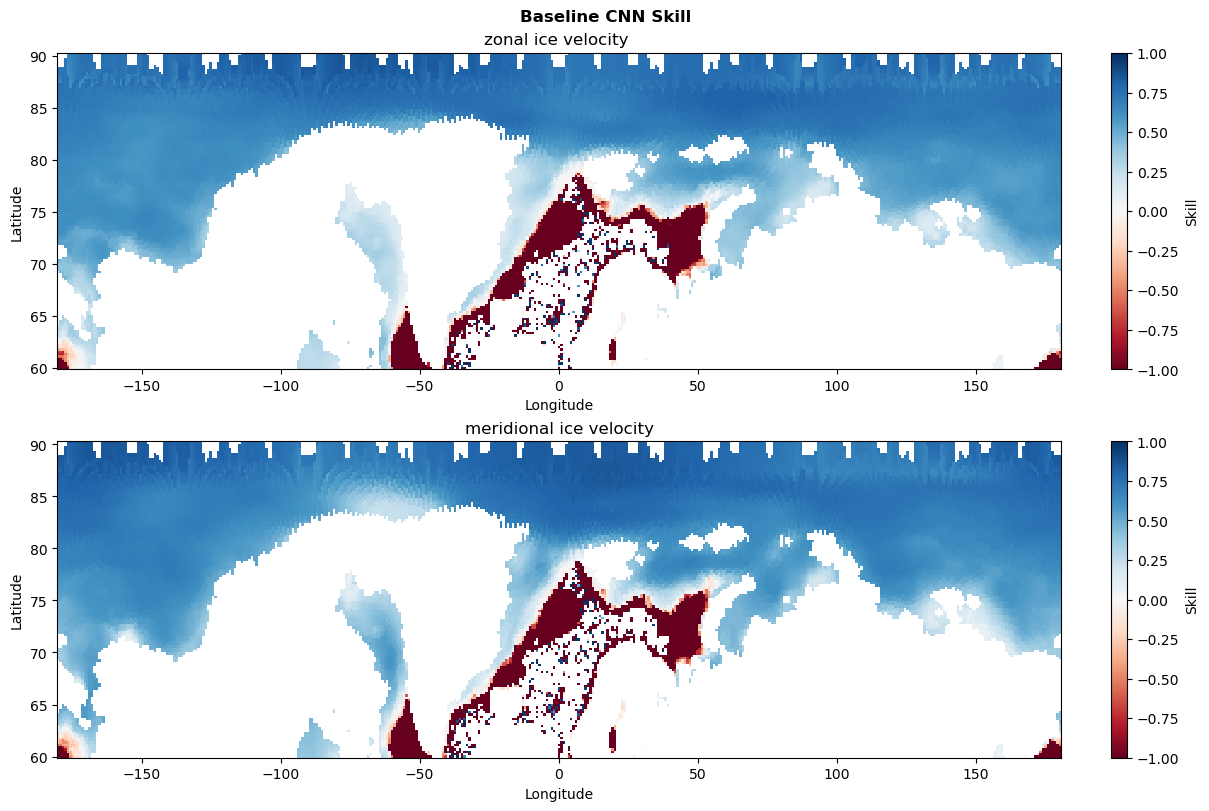

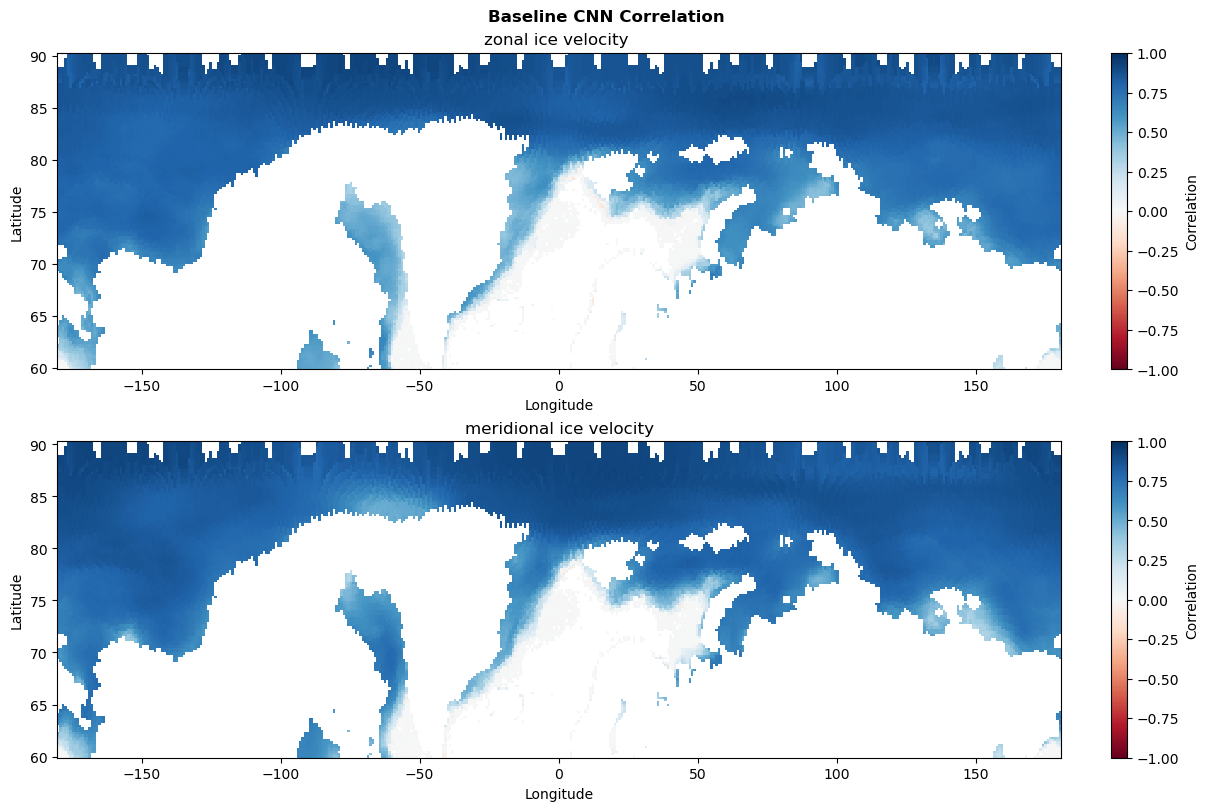

In [9]:
suC, svC = return_plot_skill(uPCun, uTCun, vPCun, vTCun, lat, lon, 'Baseline CNN')
cuC, cvC = return_plot_correlation(uPCun, uTCun, vPCun, vTCun, lat, lon, 'Baseline CNN')

/tmp/ipykernel_3565505/2545280244.py:9: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / (np.nanvar(true, axis = 0) + eps)
/tmp/ipykernel_3565505/2545280244.py:43: RuntimeWarning: Mean of empty slice
  fit_mean = np.nanmean(fit, axis = 0)
/tmp/ipykernel_3565505/2545280244.py:44: RuntimeWarning: Mean of empty slice
  true_mean = np.nanmean(true, axis = 0)
/tmp/ipykernel_3565505/2545280244.py:49: RuntimeWarning: invalid value encountered in divide
  return corr1 / (corr2)


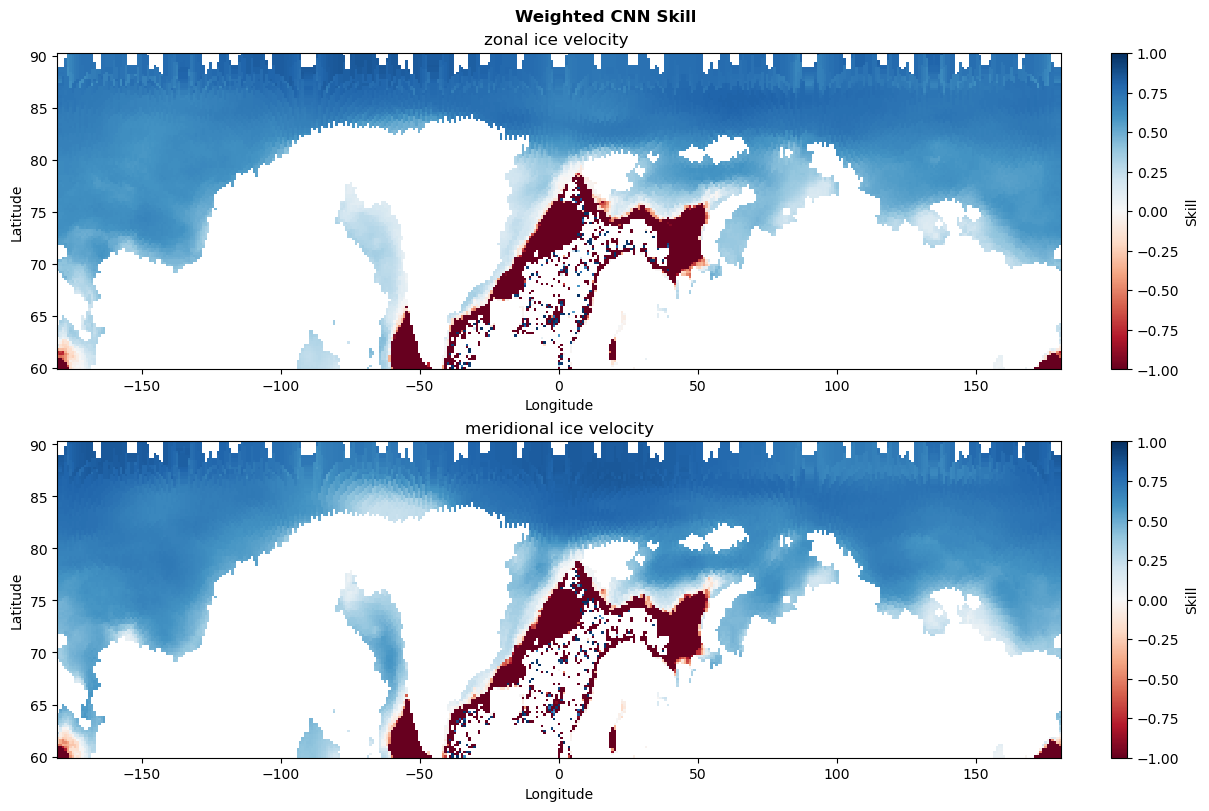

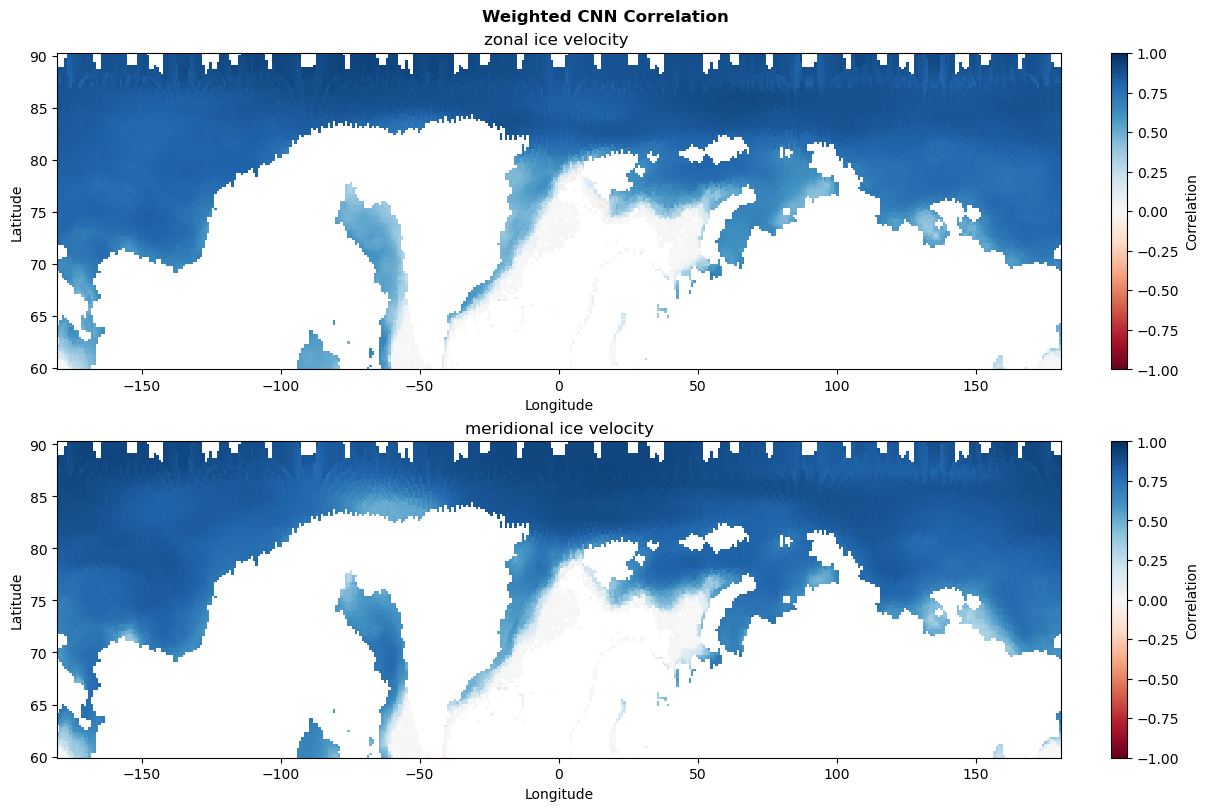

In [10]:
suW, svW = return_plot_skill(uPWun, uTWun, vPWun, vTWun, lat, lon, 'Weighted CNN')
cuW, cvW = return_plot_correlation(uPWun, uTWun, vPWun, vTWun, lat, lon, 'Weighted CNN')

/tmp/ipykernel_3565505/2545280244.py:9: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / (np.nanvar(true, axis = 0) + eps)
/tmp/ipykernel_3565505/2545280244.py:43: RuntimeWarning: Mean of empty slice
  fit_mean = np.nanmean(fit, axis = 0)
/tmp/ipykernel_3565505/2545280244.py:44: RuntimeWarning: Mean of empty slice
  true_mean = np.nanmean(true, axis = 0)
/tmp/ipykernel_3565505/2545280244.py:49: RuntimeWarning: invalid value encountered in divide
  return corr1 / (corr2)


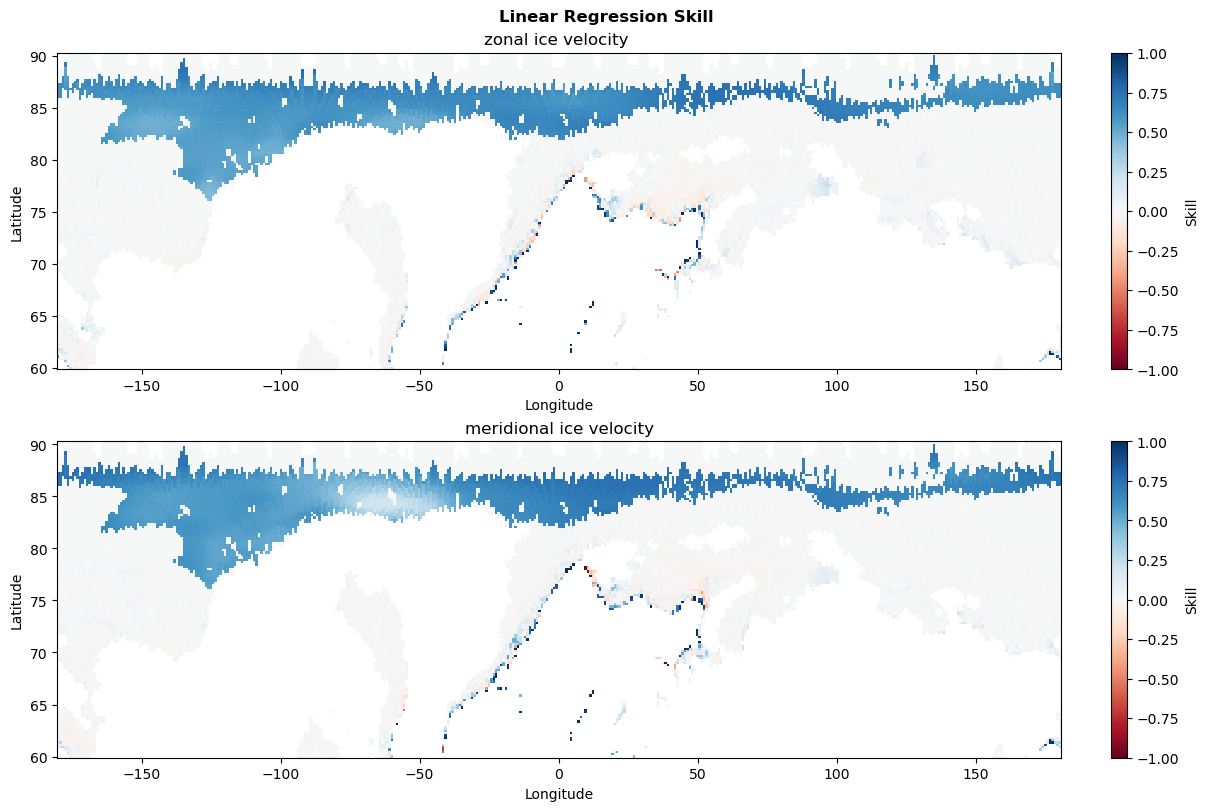

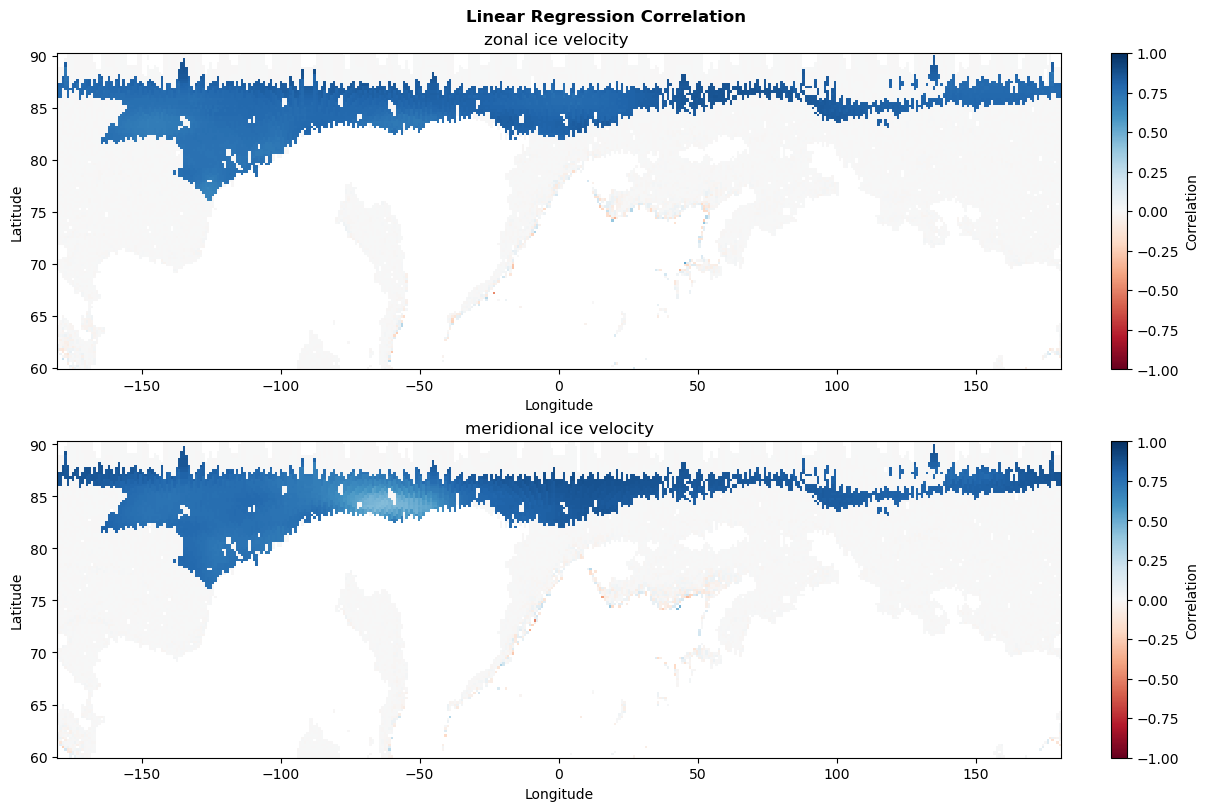

In [11]:
suL, svL = return_plot_skill(uPLun, uTLun, vPLun, vTLun, lat, lon, 'Linear Regression')
cuL, cvL = return_plot_correlation(uPLun, uTLun, vPLun, vTLun, lat, lon, 'Linear Regression')

/tmp/ipykernel_3565505/2545280244.py:9: RuntimeWarning: Degrees of freedom <= 0 for slice.
  skill = 1 - np.nanvar(true - fit, axis = 0) / (np.nanvar(true, axis = 0) + eps)
/tmp/ipykernel_3565505/2545280244.py:43: RuntimeWarning: Mean of empty slice
  fit_mean = np.nanmean(fit, axis = 0)
/tmp/ipykernel_3565505/2545280244.py:44: RuntimeWarning: Mean of empty slice
  true_mean = np.nanmean(true, axis = 0)
/tmp/ipykernel_3565505/2545280244.py:49: RuntimeWarning: invalid value encountered in divide
  return corr1 / (corr2)


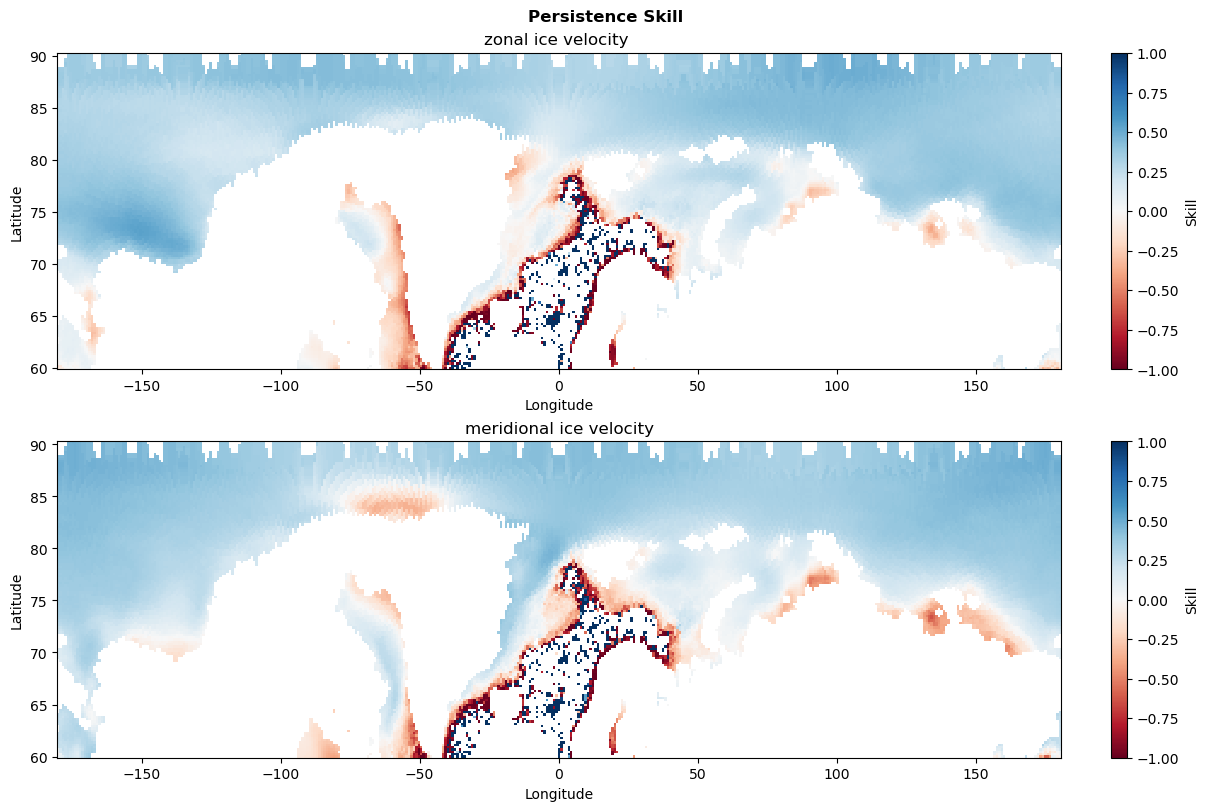

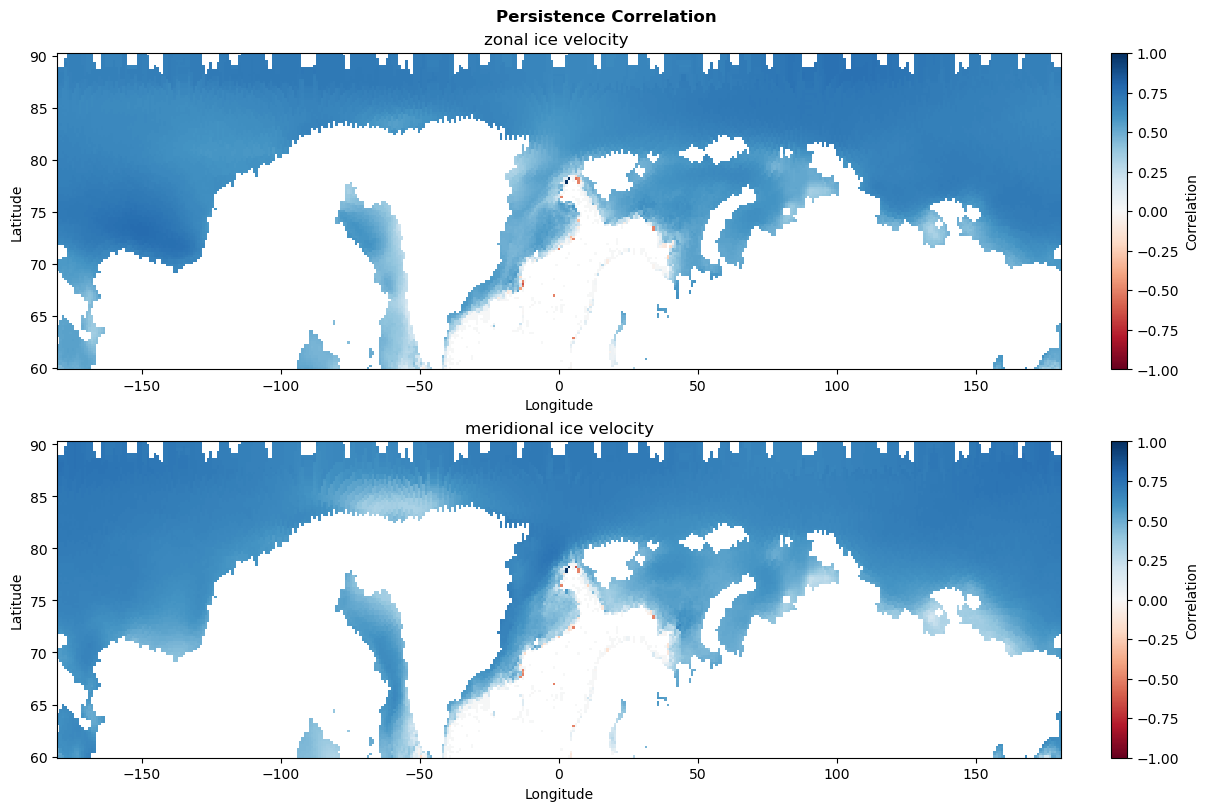

In [12]:
suB, svB = return_plot_skill(uPBun, uTBun, vPBun, vTBun, lat, lon, 'Persistence')
cuB, cvB = return_plot_correlation(uPBun, uTBun, vPBun, vTBun, lat, lon, 'Persistence')

/tmp/ipykernel_3565505/3783665262.py:1: RuntimeWarning: Mean of empty slice
  dataplt = [np.nanmean(rtTest, axis = 0), np.nanvar(rtTest, axis = 0),]
/tmp/ipykernel_3565505/3783665262.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice.
  dataplt = [np.nanmean(rtTest, axis = 0), np.nanvar(rtTest, axis = 0),]


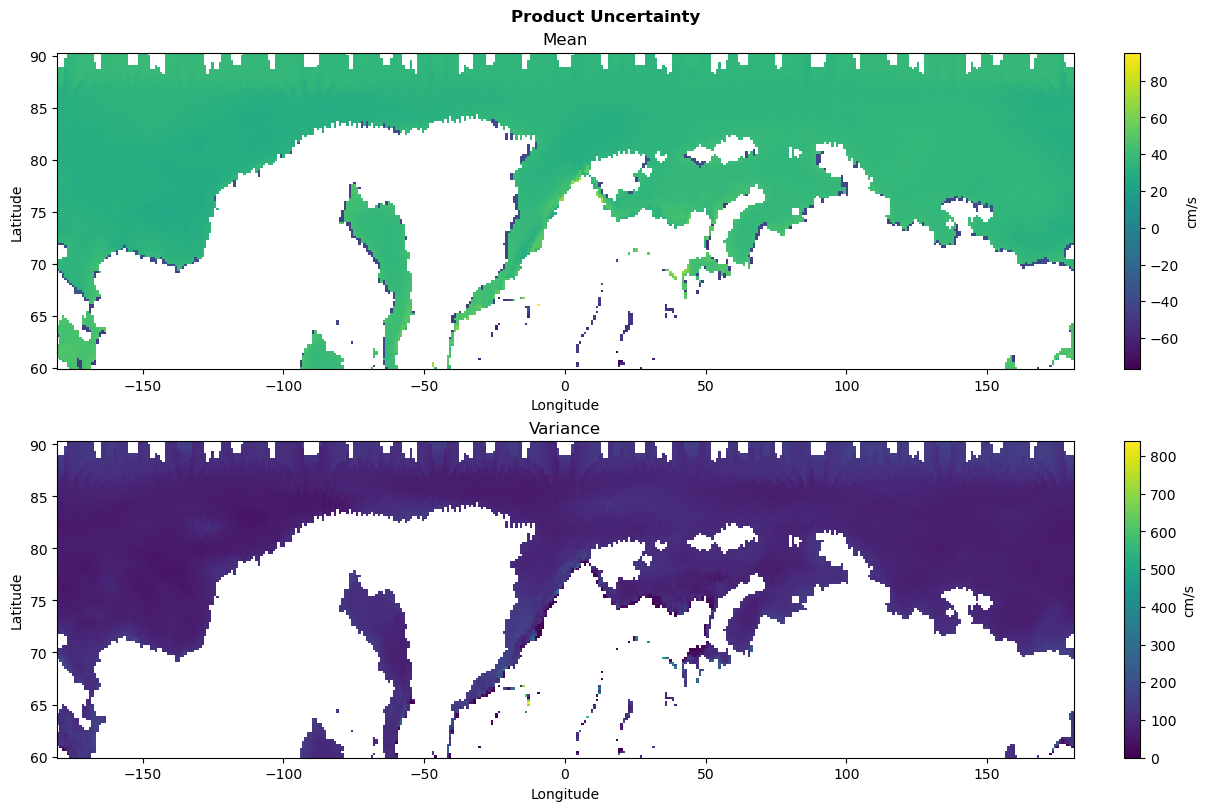

In [13]:
dataplt = [np.nanmean(rtTest, axis = 0), np.nanvar(rtTest, axis = 0),]
nd = len(dataplt)
titles = ['Mean', 'Variance']

fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*4), constrained_layout=True)

for i in range(nd):
    pcm = axs[i].pcolormesh(lon, lat, dataplt[i])
    fig.colorbar(pcm, ax=axs[i], label = 'cm/s')
    axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')

fig.suptitle(r'Product Uncertainty', fontweight = 'bold')

# # Save plot
# fnam = f'UncPlot.jpeg'
# plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')

plt.show()

In [18]:
def delta_plot(u1, v1, u2, v2, str1, str2, metric_str):

    vmin = -1
    vmax = 1
    cmap = plt.cm.RdBu
    
    delta_u =  u1 - u2
    delta_v =  v1 - v2

    data = [delta_u, delta_v]
    nd = len(data)
    titles = ['zonal ice velocity ', 'meridional ice velocity']
    
    fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*4), constrained_layout=True)
    
    for i in range(nd):
        pcm = axs[i].pcolormesh(lon, lat, data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pcm, ax=axs[i], label=r'$\Delta$')
        axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')
        
    fig.suptitle(rf"$\Delta {metric_str}({str1}, {str2})$", fontweight = 'bold')

    # Save plot
    fnam = rf"Delta_{metric_str}{str1}{str2}.jpeg"
    plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')

    plt.show()

    return

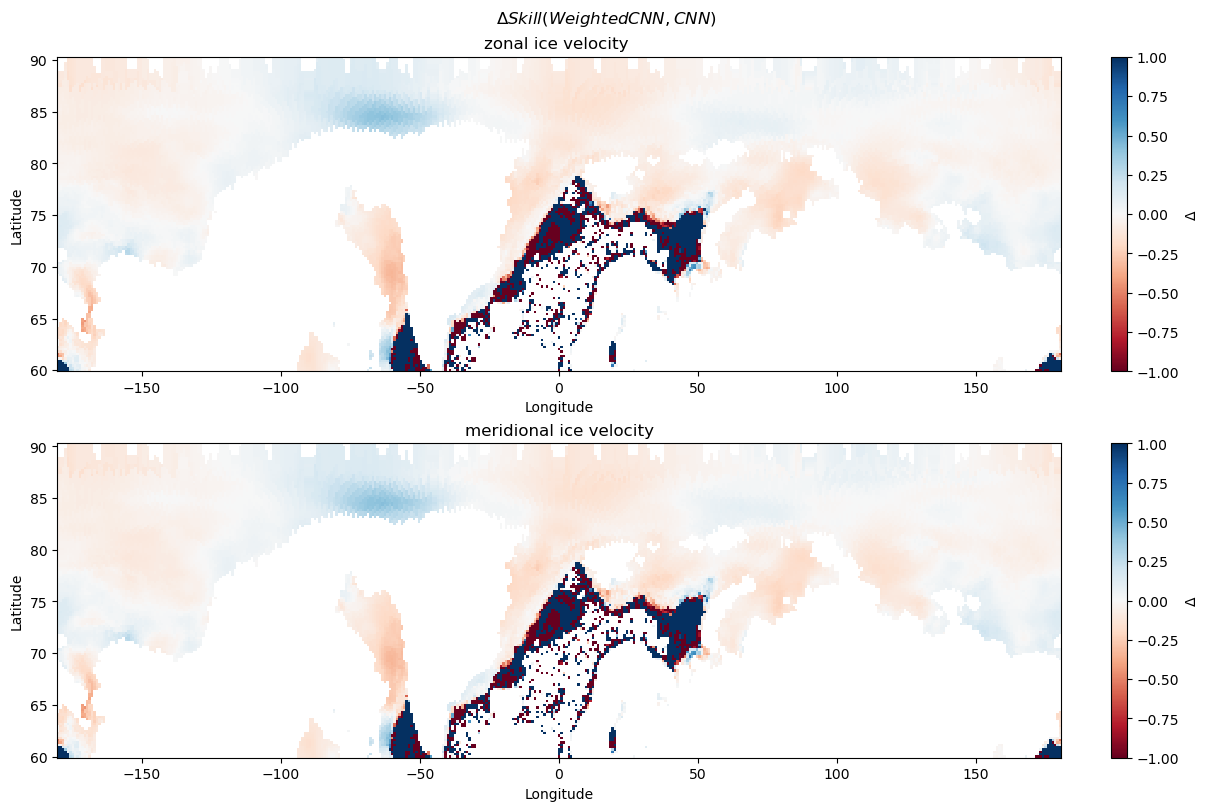

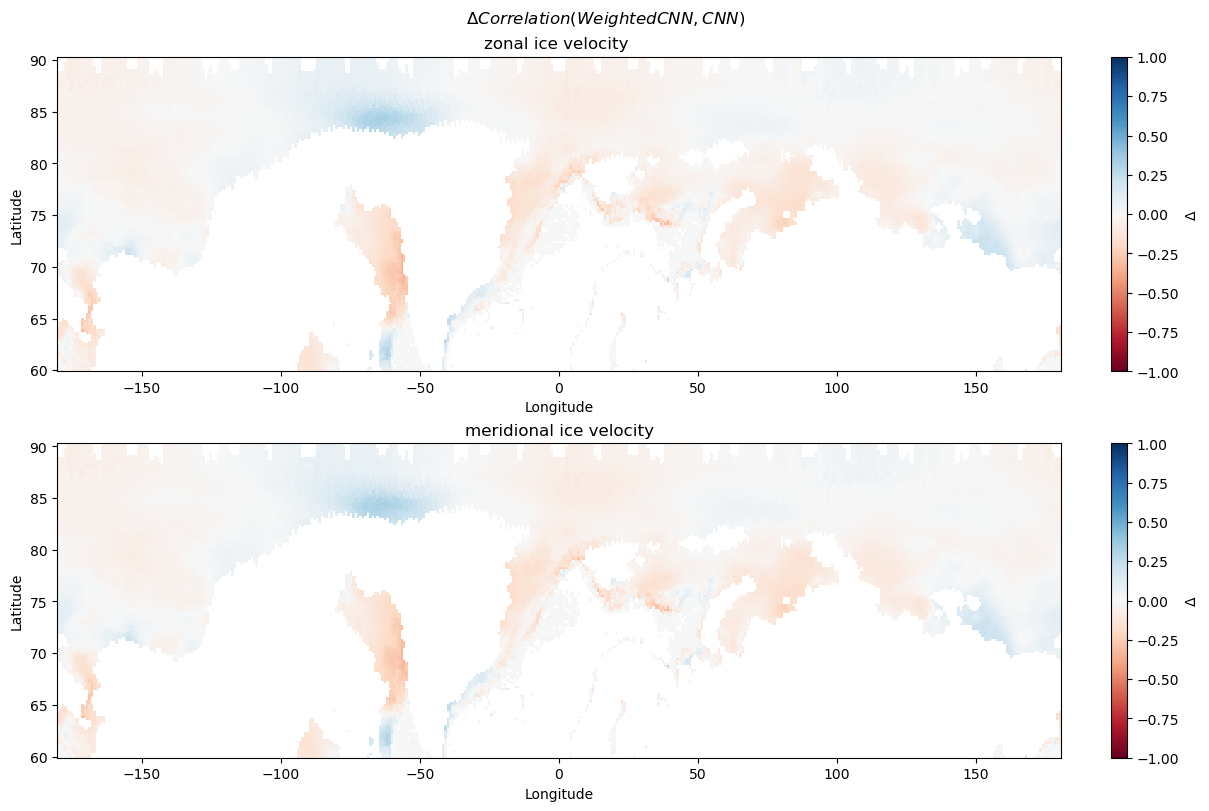

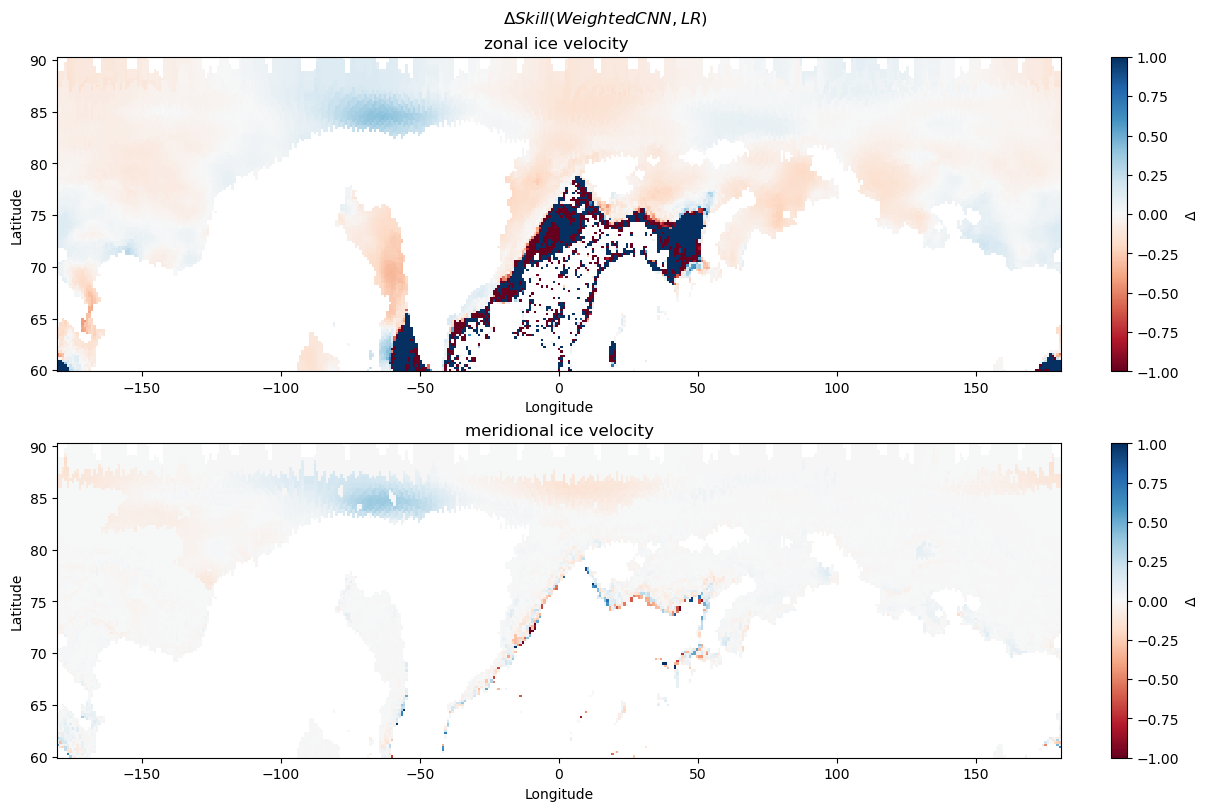

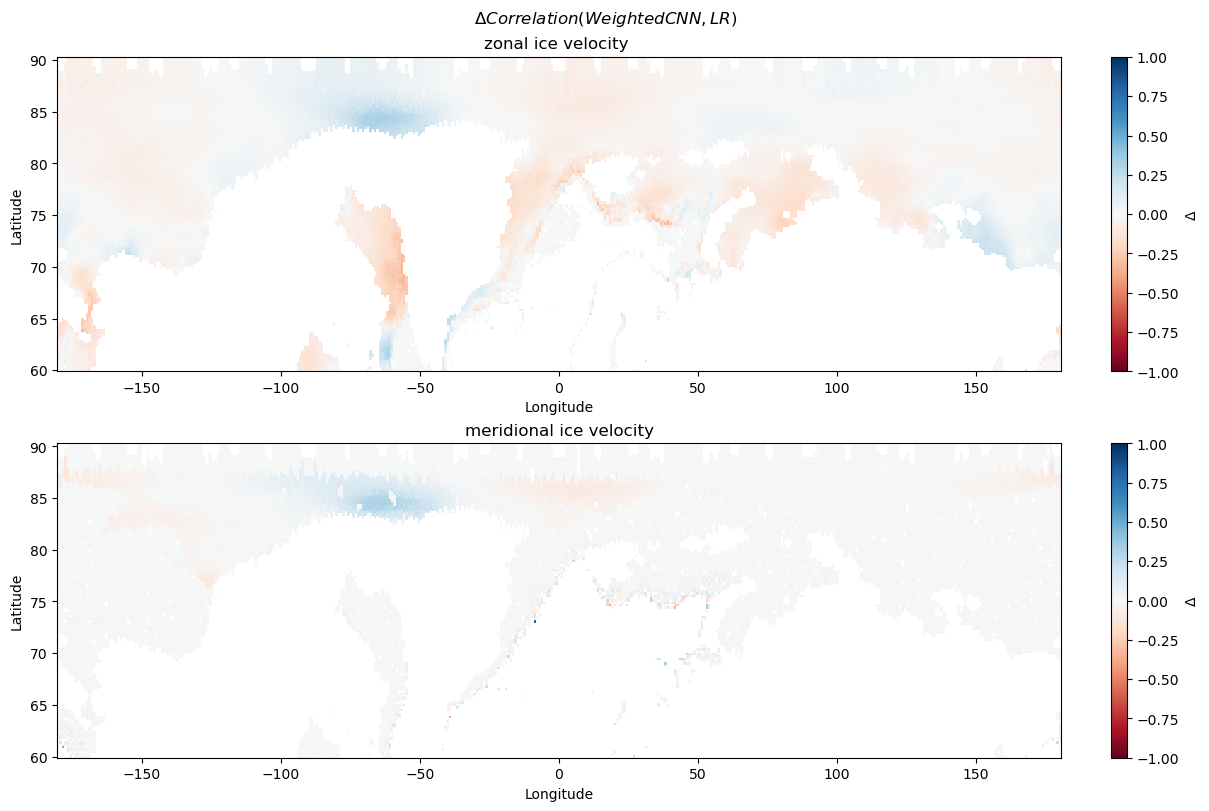

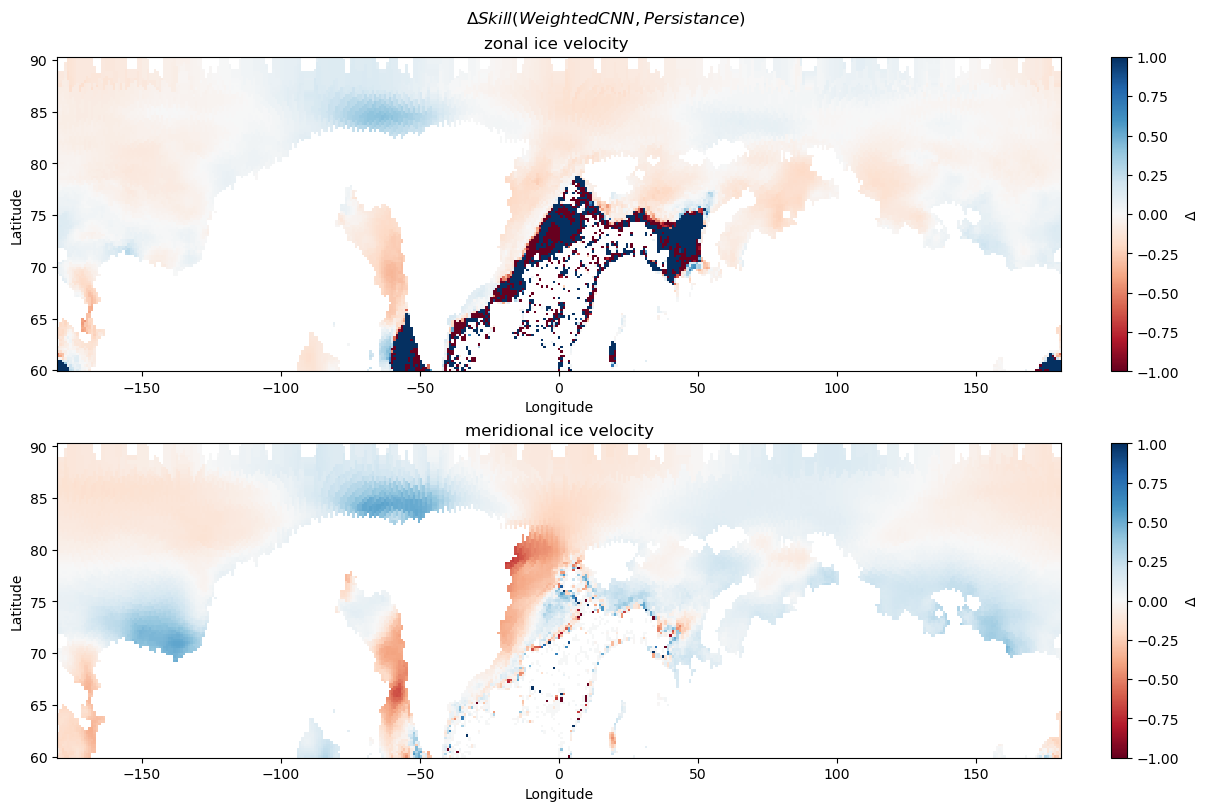

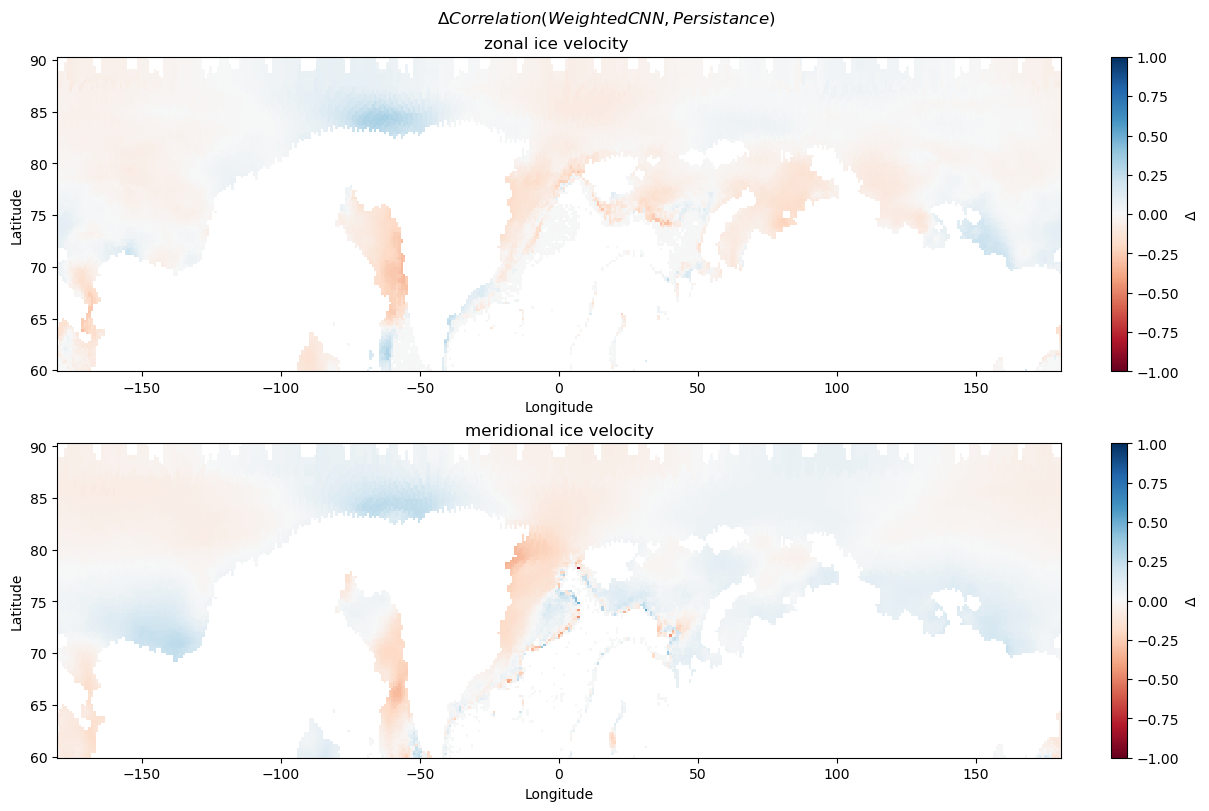

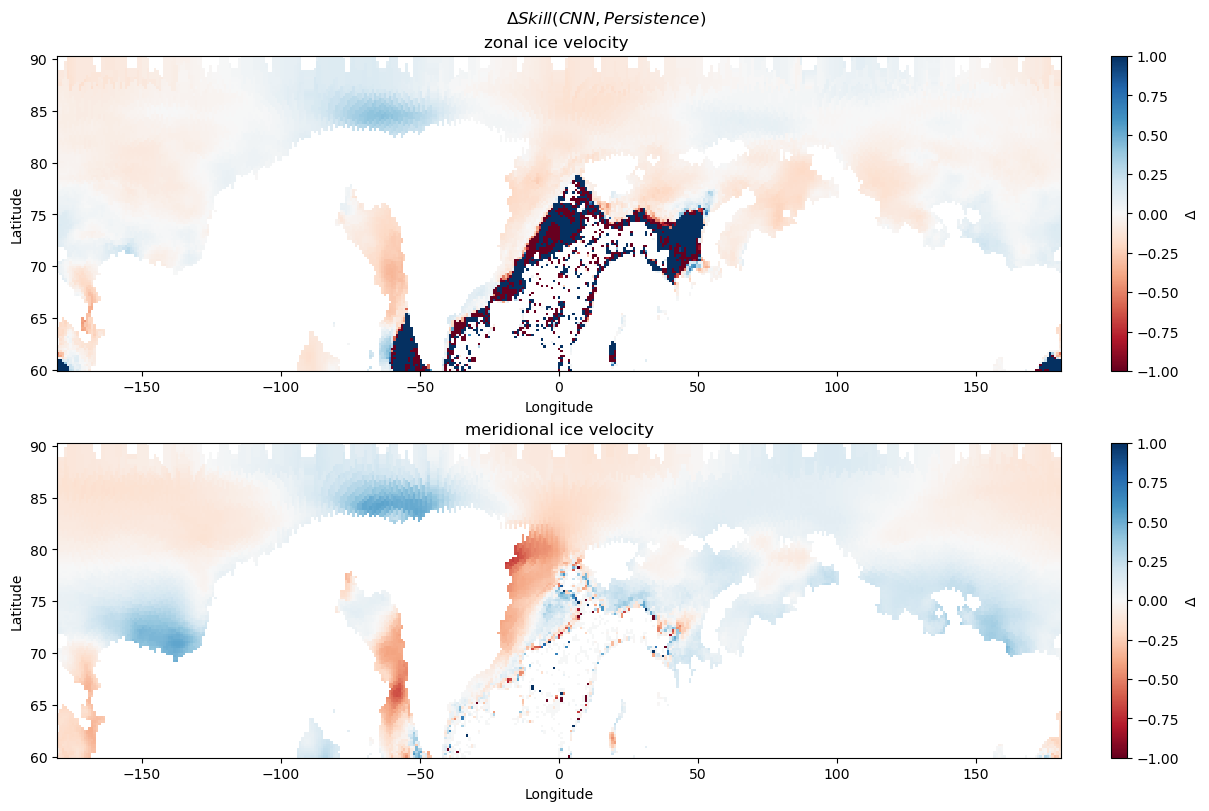

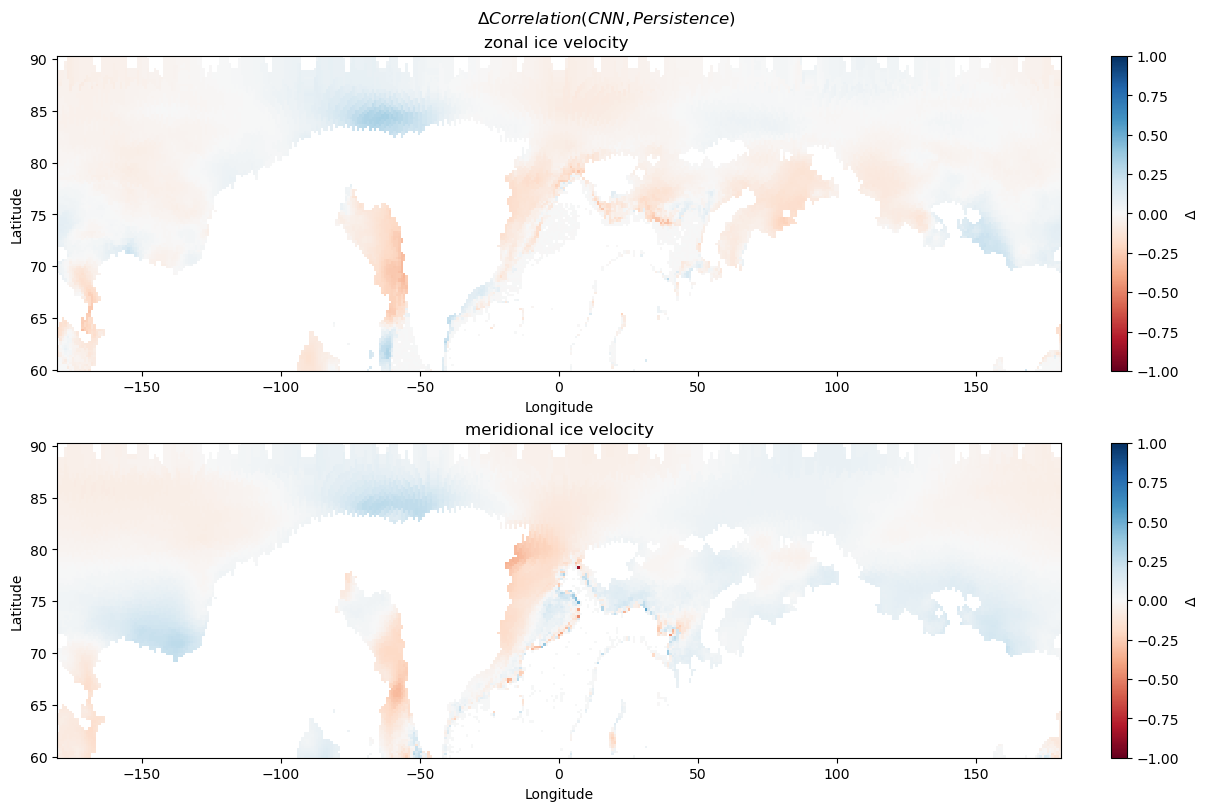

In [19]:
delta_plot(suW, suC, svW, svC, "Weighted CNN", "CNN", "Skill")
delta_plot(cuW, cuC, cvW, cvC, "Weighted CNN", "CNN", "Correlation")

delta_plot(suW, suL, svW, svL, "Weighted CNN", "LR", "Skill")
delta_plot(cuW, cuL, cvW, cvL, "Weighted CNN", "LR", "Correlation")

delta_plot(suW, suB, svW, svB, "Weighted CNN", "Persistance", "Skill")
delta_plot(cuW, cuB, cvW, cvB, "Weighted CNN", "Persistance", "Correlation")

delta_plot(suC, suB, svC, svB, "CNN", "Persistence", "Skill")
delta_plot(cuC, cuB, cvC, cvB, "CNN", "Persistence", "Correlation")

In [51]:
# Plot Time Series

def plot_time_series(u_pred, u_true, v_pred, v_true, time, y_idx, x_idx, model_str):

    if lon[x_idx] < 0:
        lon_str = r'$\degree $W'
    else:
        lon_str = r'$\degree $E'
        
    lat_str = r'$ \degree $N'

    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 12))

    plt1 = axs[0].plot(time[-365:], u_true[-365:,y_idx,x_idx], label = 'true')
    plt2 = axs[0].plot(time[-365:],u_pred[-365:,y_idx,x_idx], label = 'predicted')
    axs[0].legend()
    axs[0].set_title('Zonal Ice Velocity', fontweight = 'bold')
    axs[0].set_ylabel("cm/s", fontsize = '12')

    plt3 = axs[1].plot(time[-365:],v_true[-365:,y_idx,x_idx], label = 'true')
    plt4 = axs[1].plot(time[-365:],v_pred[-365:,y_idx,x_idx], label = 'predicted')
    axs[1].legend()
    axs[1].set_title('Meridional Ice Velocity', fontweight = 'bold')
    axs[1].set_ylabel("cm/s", fontsize = '12')

    # Save plot
    fnam = f"{model_str}time_series.jpeg"
    plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')

    fig.suptitle(f'{model_str} Forecast: {np.abs(lat[y_idx]):.1f} {lat_str}, {np.abs(lon[x_idx]):.1f} {lon_str}', fontweight = 'bold')
    fig.tight_layout()

    plt.show()

    return

In [56]:
# Plot Time Series

def plot_time_series_bad_loc(u_pred, u_true, v_pred, v_true, time, y_idx, x_idx, model_str):

    if lon[x_idx] < 0:
        lon_str = r'$\degree $W'
    else:
        lon_str = r'$\degree $E'
        
    lat_str = r'$ \degree $N'

    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 12))

    plt1 = axs[0].plot(time[-365:], u_true[-365:,y_idx,x_idx], label = 'true')
    plt2 = axs[0].plot(time[-365:],u_pred[-365:,y_idx,x_idx], label = 'predicted')
    axs[0].legend()
    axs[0].set_title('Zonal Ice Velocity', fontweight = 'bold')
    axs[0].set_ylabel("cm/s", fontsize = '12')

    plt3 = axs[1].plot(time[-365:],v_true[-365:,y_idx,x_idx], label = 'true')
    plt4 = axs[1].plot(time[-365:],v_pred[-365:,y_idx,x_idx], label = 'predicted')
    axs[1].legend()
    axs[1].set_title('Meridional Ice Velocity', fontweight = 'bold')
    axs[1].set_ylabel("cm/s", fontsize = '12')

    # Save plot
    fnam = f"{model_str}time_seriesBadLoc.jpeg"
    plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')

    fig.suptitle(f'{model_str} Forecast: {np.abs(lat[y_idx]):.1f} {lat_str}, {np.abs(lon[x_idx]):.1f} {lon_str} (High Uncertainty Location)', fontweight = 'bold')
    fig.tight_layout()

    plt.show()

    return

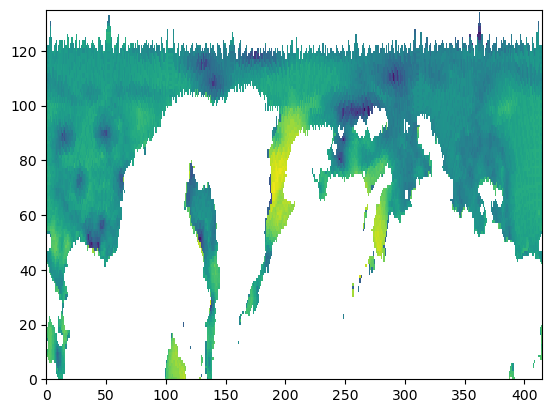

In [57]:
plt.pcolormesh(rt[1,:,:])

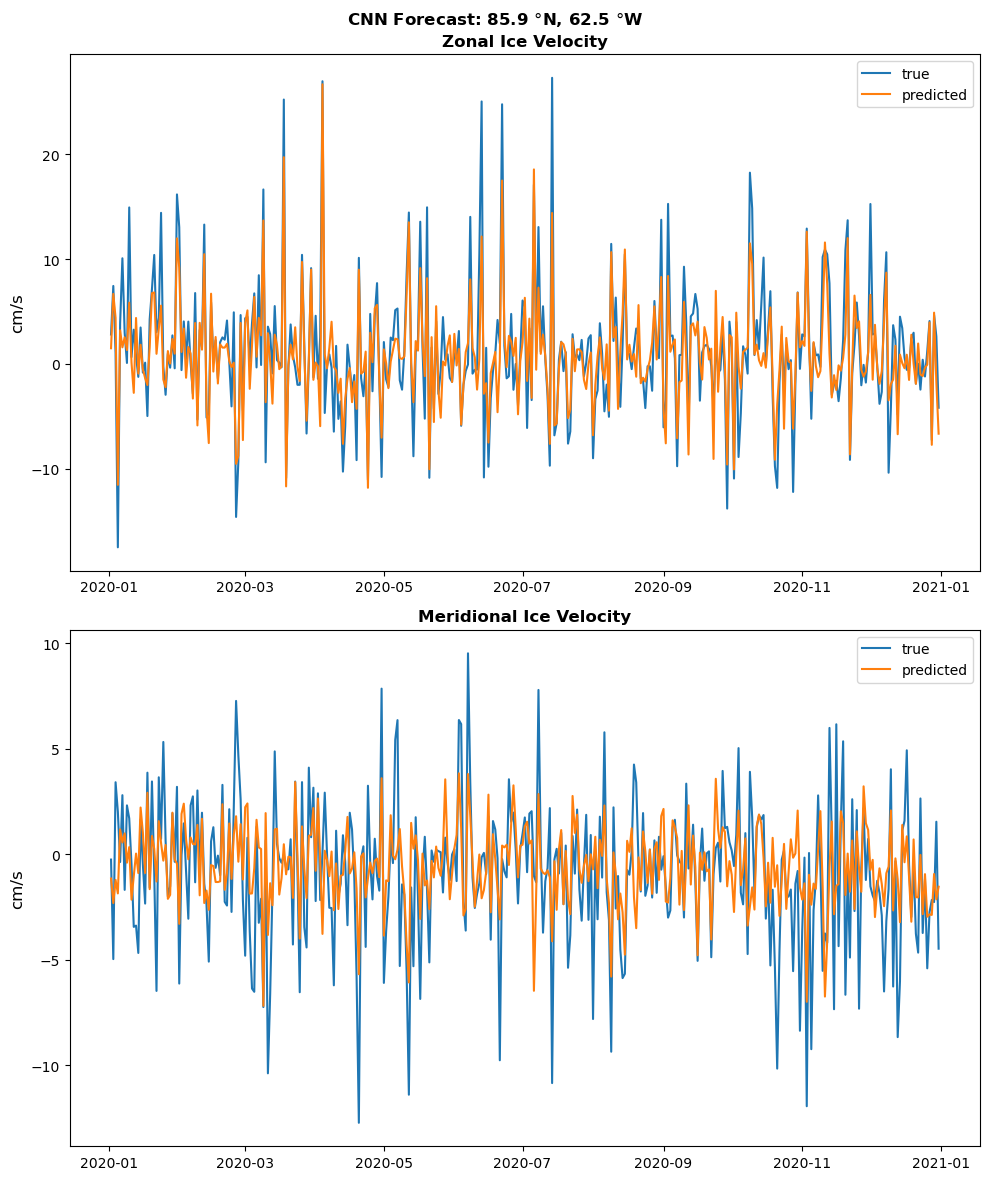

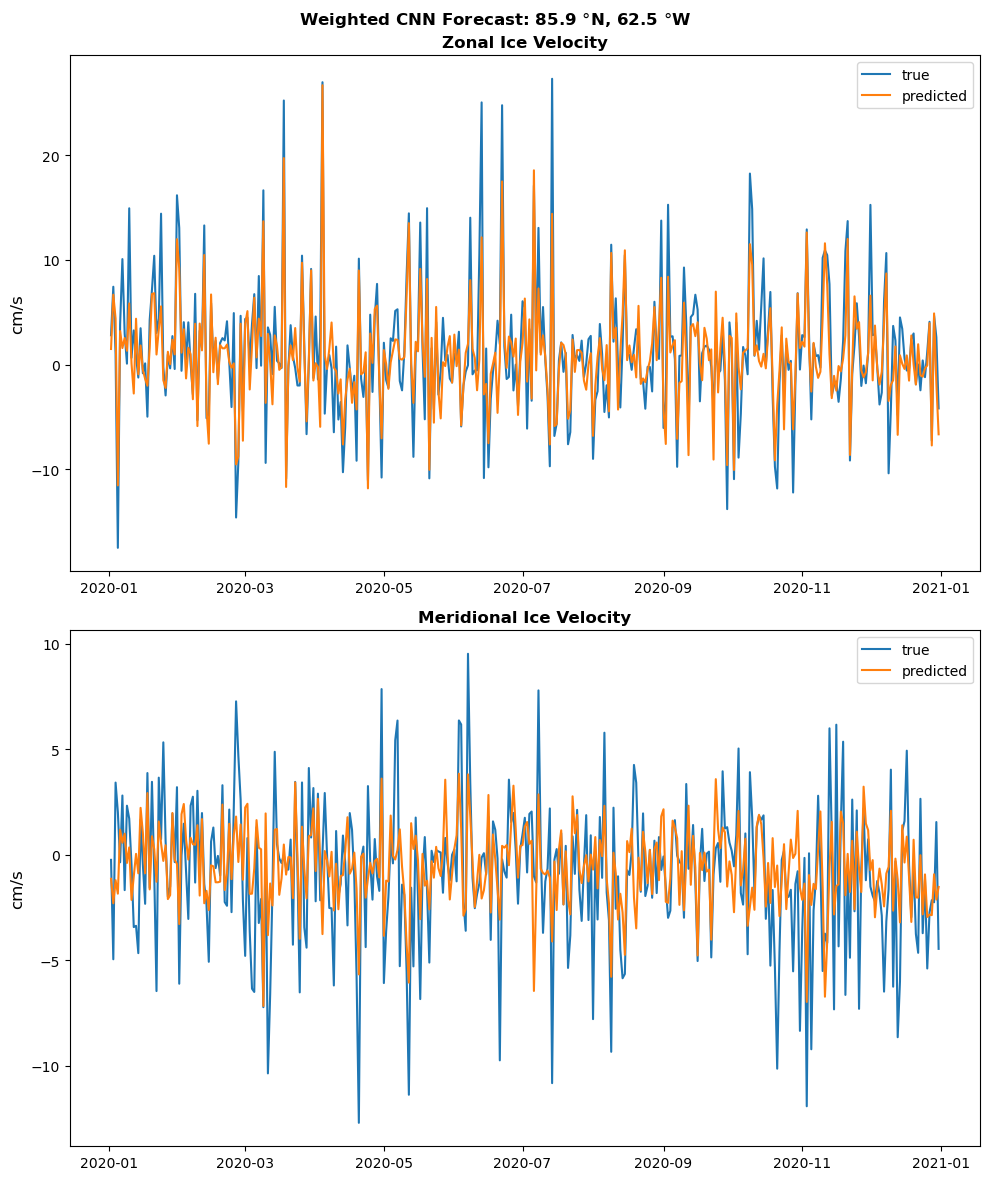

In [58]:
# Good Location

x_idx = 135
y_idx = 115

plot_time_series(uPCun, uTCun, vPCun, vTCun, time_today, y_idx, x_idx, "CNN")
plot_time_series(uPWun, uTWun, vPWun, vTWun, time_today, y_idx, x_idx, "Weighted CNN")

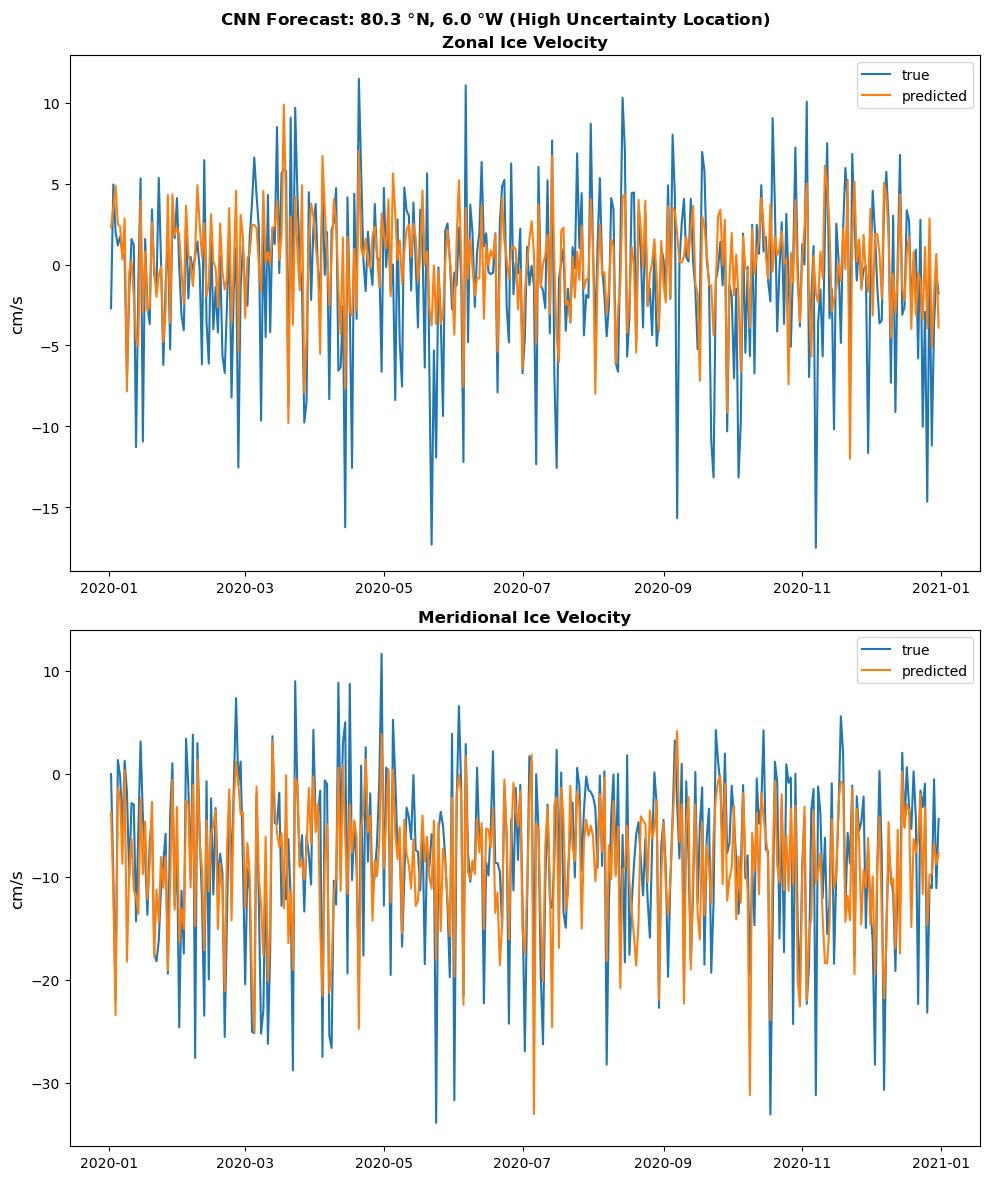

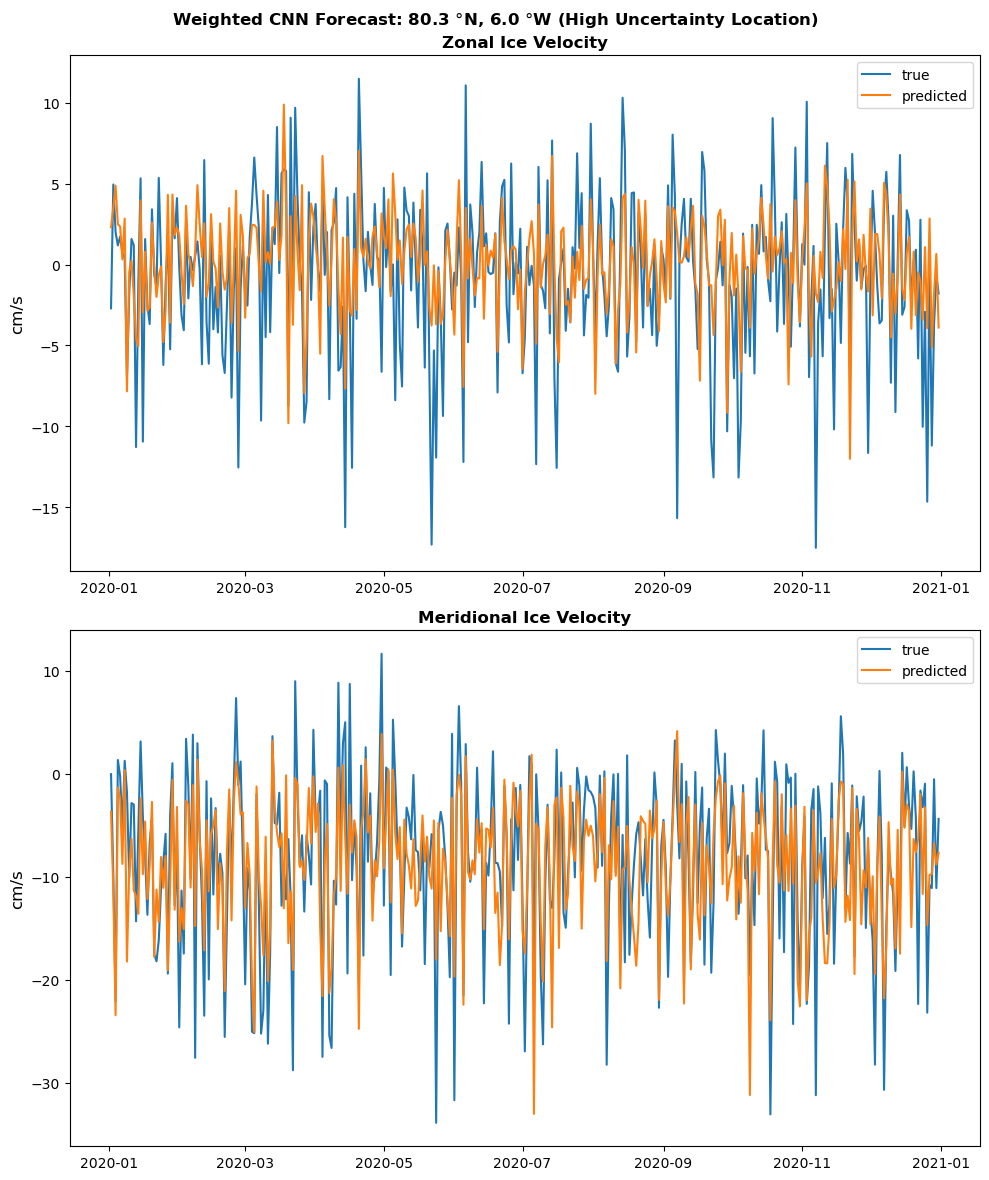

In [59]:
# Bad Location

x_idx = 200
y_idx = 90

plot_time_series_bad_loc(uPCun, uTCun, vPCun, vTCun, time_today, y_idx, x_idx, "CNN")
plot_time_series_bad_loc(uPWun, uTWun, vPWun, vTWun, time_today, y_idx, x_idx, "Weighted CNN")

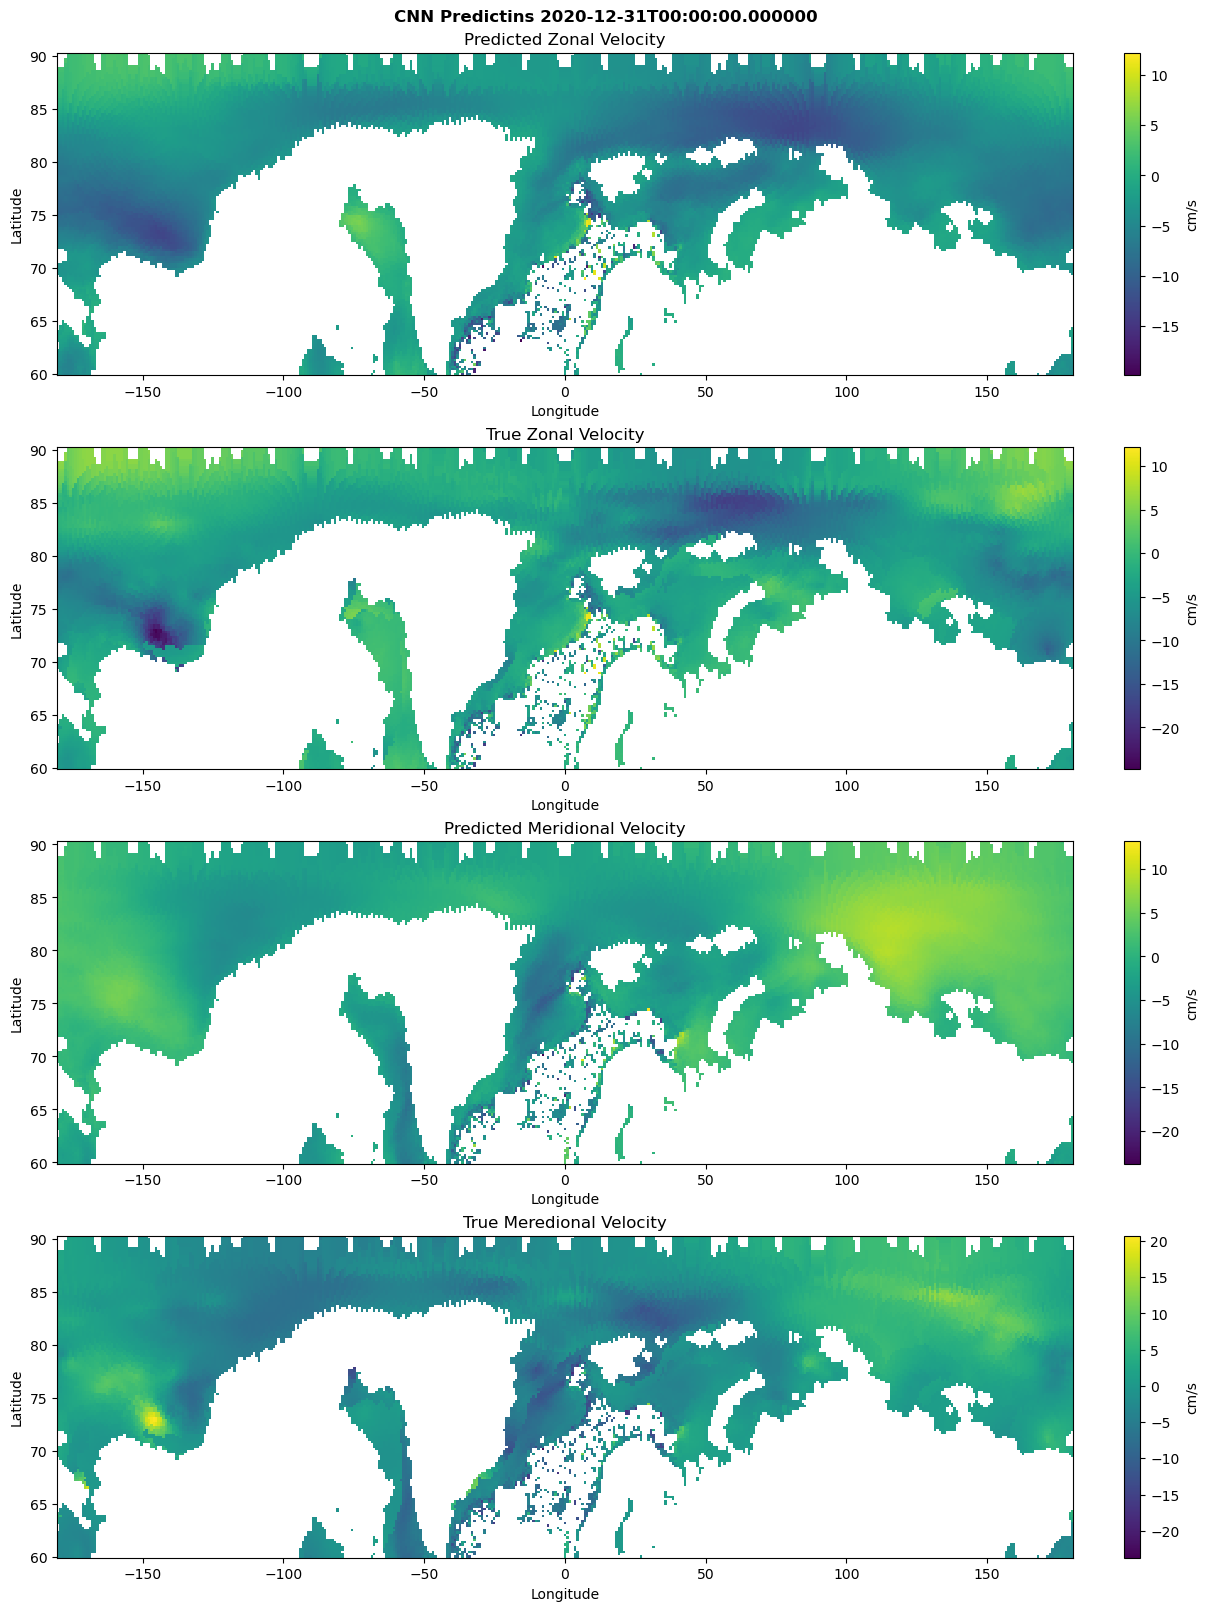

In [61]:
dataplt = [uPCun[-1,:,:], uTCun[-1,:,:], vPCun[-1,:,:], vTCun[-1,:,:]]
nd = len(dataplt)
titles = ['Predicted Zonal Velocity', 'True Zonal Velocity', 'Predicted Meridional Velocity', 'True Meredional Velocity']

fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*4), constrained_layout=True)

for i in range(nd):
    pcm = axs[i].pcolormesh(lon, lat, dataplt[i])
    fig.colorbar(pcm, ax=axs[i], label = 'cm/s')
    axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')

fig.suptitle(f'CNN Predictins {time_today[-1]}', fontweight = 'bold')

# Save plot
fnam = f'CNNPredMap.jpeg'
plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')

plt.show()

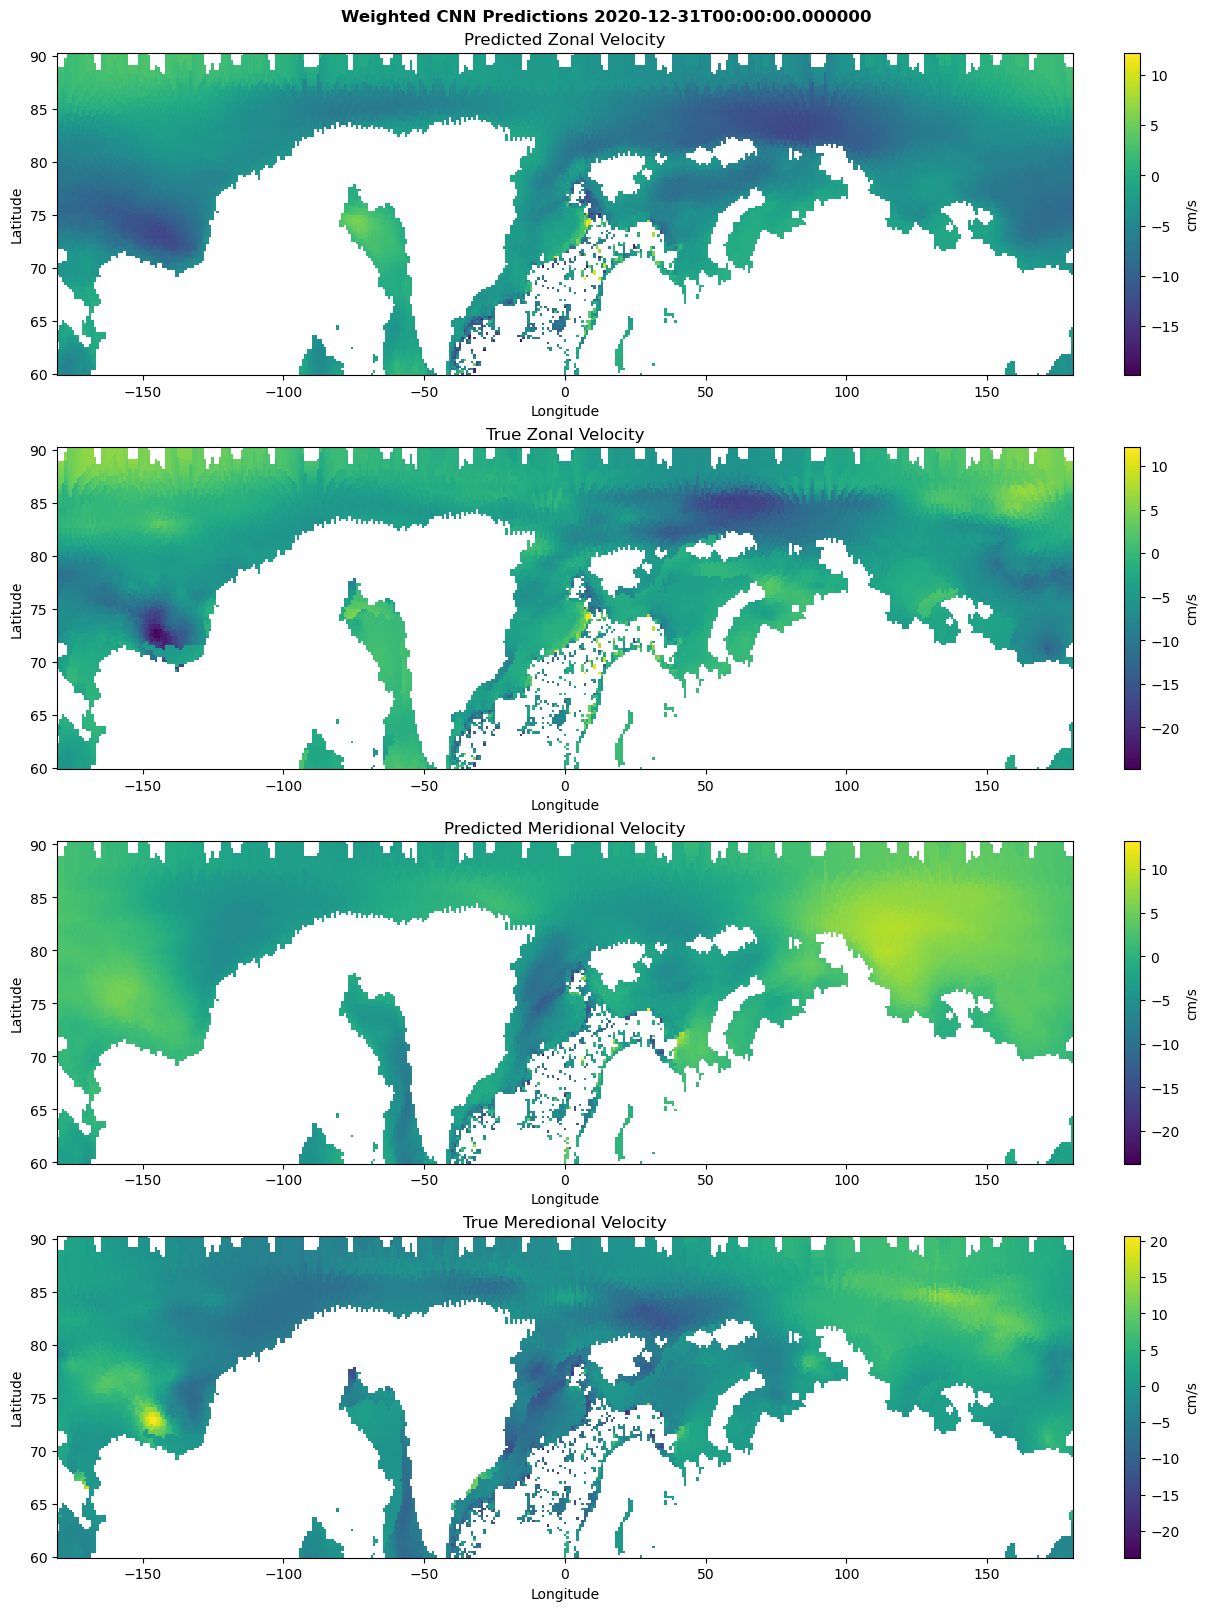

In [62]:
dataplt = [uPWun[-1,:,:], uTWun[-1,:,:], vPWun[-1,:,:], vTWun[-1,:,:]]
nd = len(dataplt)
titles = ['Predicted Zonal Velocity', 'True Zonal Velocity', 'Predicted Meridional Velocity', 'True Meredional Velocity']

fig, axs = plt.subplots(nrows=nd, ncols=1, figsize=(12, nd*4), constrained_layout=True)

for i in range(nd):
    pcm = axs[i].pcolormesh(lon, lat, dataplt[i])
    fig.colorbar(pcm, ax=axs[i], label = 'cm/s')
    axs[i].set(title=titles[i], xlabel='Longitude', ylabel='Latitude')

fig.suptitle(f'Weighted CNN Predictions {time_today[-1]}', fontweight = 'bold')

# Save plot
fnam = f'WeightedCNNPredMap.jpeg'
plt.savefig(os.path.join(PATH_DEST, fnam), dpi=300, format='jpeg')

plt.show()